In [43]:
import math
import json
import random
import ast
import re
import time
from datetime import datetime as dt
from os import path
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation, CompoundLocation
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from scipy import stats
from collections import Counter
from itertools import combinations

#### Some universal functions for reading in data from nextstrain builds

In [44]:
def readin_virus_config(virus):
    """
    Read in the config file for this virus to get the paths to alignment, metadata files, etc 
    as well as metadata about the virus such as how many subtypes, 
    and which genes are receptor-binding or polymerase
    """
    config_json = f'config/adaptive_evo_config_{virus}.json'
    with open(config_json) as json_handle:
        configs = json.load(json_handle)
        
    return configs

### Get data for this virus, subtype, gene and organize for the adaptation analysis

In [62]:
def subset_viruses_nextstrain_build(virus, subtype, gene, window, min_seqs, year_max, year_min):
    
    """
    Read in the alignment file for the specified virus and subtype, and extract the specified gene sequence. 
    Divide the alignment into temporal windows depending on the specified `window` argument (in years).
    Each temporal window must contain a minimum or `min_seqs` sequences, otherwise it will be excluded as missing data.
    The analysis can be limited to a certain time range by supplying `year_max` and/or `year_min`.
    """
    
    configs = readin_virus_config(virus)
    
    #some dengue files are shared between all genotypes of the same serotype
    if virus=='dengue':
        serotype = subtype.split('_')[0]
    else:
        serotype = False
    
    subunit = False
    #find if gene is a subunit of surface protein
    if subtype==None:
        gene_location_key = "location"
    else:
        #dengue reference files and locations are shared among serotypes
        if serotype:
            gene_location_key = "location_"+str(serotype)
        else:
            gene_location_key = "location_"+str(subtype)
            
    if gene.upper() == configs['receptor_binding']['virus_gene'].upper():
        if "specify_location" in configs['receptor_binding'].keys():
            subunit = True
            parent_gene = configs['receptor_binding']['specify_location']['parent_gene']
            gene_location_list = ast.literal_eval(configs['receptor_binding']['specify_location'][gene_location_key])
    elif gene.upper() == configs['membrane_fusion']['virus_gene'].upper():
        if "specify_location" in configs['membrane_fusion'].keys():
            subunit = True
            parent_gene = configs['membrane_fusion']['specify_location']['parent_gene']
            gene_location_list = ast.literal_eval(configs['membrane_fusion']['specify_location'][gene_location_key])
        
    #Find reference, alignment and meta files (some sub-genic regions may use files from a gene or a whole genome)
    if subunit:
        alignment_file = configs['alignment_file'].format(virus=virus, subtype=subtype, gene=parent_gene)
        meta_file = configs['meta_file'].format(virus=virus, subtype=subtype, gene=parent_gene)
        #some are comma-separated, some are tab-separated
        metafile_sep = configs['metafile_sep']
    else:
        alignment_file = configs['alignment_file'].format(virus=virus, subtype=subtype, gene=gene)
        meta_file = configs['meta_file'].format(virus=virus, subtype=subtype, gene=gene)
        metafile_sep = configs['metafile_sep']
        #dengue reference files are shared among serotypes
        if serotype:
            reference_file = configs['reference_file'].format(virus=virus, subtype=serotype, gene=gene)
        else:
            reference_file = configs['reference_file'].format(virus=virus, subtype=subtype, gene=gene)
    

    
    # if a minimum year to use is supplied in config, limit seqs to this
    if 'min_year' in configs.keys():
        year_min = int(configs['min_year'])
    
    #Find gene location, if domain is sub-genic or reference file contains multiple genes
    gene_location = False
    #If domain is sub-genic, fetch its position (within genome or parent gene) from config file

    if subunit:
        #Need to deal with domains the are not contiguous
        if len(gene_location_list)==1:
            gene_location = SeqFeature(FeatureLocation(gene_location_list[0][0], gene_location_list[0][1]))
        else:
            compound_locations = []
            for location in gene_location_list:
                compound_locations.append(FeatureLocation(location[0], location[1]))
            gene_location = CompoundLocation(compound_locations)

    #for reference files where the gene is named differently
    #like for fluC, where the segment is NS, but it contains NS1 and NS2
    elif 'specify_locations' in configs.keys() and gene in configs['specify_locations'].keys():       
        gene_location_list = ast.literal_eval(configs['specify_locations'][gene])
        gene_location = SeqFeature(FeatureLocation(gene_location_list[0][0], gene_location_list[0][1]))

    #Find gene location from reference files
    else:
        for seq_record in SeqIO.parse(reference_file, "genbank"):
            for feature in seq_record.features:
                if feature.type == 'CDS':
                    if 'gene' in feature.qualifiers.keys():
                        if feature.qualifiers['gene'][0].lower() == gene.lower():
                            gene_location = feature.location
                    if gene_location==False:
                        if 'product' in feature.qualifiers.keys():
                            if feature.qualifiers['product'][0].lower() == gene.lower():
                                gene_location = feature.location
                    if gene_location == False:
                        if 'locus_tag' in feature.qualifiers.keys():
                            if feature.qualifiers['locus_tag'][0].lower() == gene.lower():
                                gene_location = feature.location  
                        

    #Subset data based on time windows
    meta = pd.read_csv(meta_file, sep = metafile_sep)
    #drop incomplete date data
    meta.drop(meta[meta['date']=='?'].index, inplace=True)
    meta = meta[meta["date"].str.contains("20XX")==False]
    meta = meta[meta["date"].str.contains("36-0")==False]
    meta.dropna(subset=['date'], inplace=True)
    meta['year'] = meta['date'].str[:4].astype('int')
    if year_max:
        meta.drop(meta[meta['year']>year_max].index, inplace=True)
    if year_min:
        meta.drop(meta[meta['year']<year_min].index, inplace=True)
    
    date_range = meta['year'].max() - meta['year'].min()
    #Remove egg- and cell-passaged strains
    meta.drop(meta[meta['strain'].str[-4:]=='-egg'].index, inplace=True)
    meta.drop(meta[meta['strain'].str[-5:]=='-cell'].index, inplace=True)
    
    #Limit meta data to only strains in alignment file
    aligned_isolates = []
    with open(alignment_file, "r") as aligned_handle:
        for isolate in SeqIO.parse(aligned_handle, "fasta"):
            aligned_isolates.append(isolate.id)
    aligned_isolates_df = pd.DataFrame(aligned_isolates, columns=['strain'])
    meta = meta.merge(aligned_isolates_df, on='strain', how='inner')
    
    
    #Group viruses by time windows
    virus_time_subset = {}
    if window == 'all':
        years = str(meta['year'].min()) + '-' + str(meta['year'].max())
        virus_time_subset[years] = meta['strain'].tolist()
    else:
        date_window_start = meta['year'].min()
        date_window_end = meta['year'].min() + window
        while date_window_end <= meta['year'].max():
            years = str(date_window_start) + '-' + str(date_window_end)
            strains = meta[(meta['year']>=date_window_start) & (meta['year']<date_window_end)]['strain'].tolist()
            virus_time_subset[years] = strains
            
            
            #sliding window
            date_window_end += 1
            date_window_start += 1 
    

    #Only use time points with enough data:
    virus_time_subset = {k:v for k,v in virus_time_subset.items() if len(v)>=min_seqs}
    
    year_windows = []
    seqs_in_window = []
    
    #Find outgroup sequence from strains at first time point(to make consensus from)
    first_window = True
    first_window_strains = []
    first_window_sequences = []
    
    alignment_time_subset = {}

    
    for years, subset_viruses in virus_time_subset.items():

        year_windows.append(years)
        seqs_in_window.append(len(subset_viruses))
        alignment_time_subset[years] = []

        #make consensus sequence at first time point
        if first_window == True:
            first_window_strains+=subset_viruses
            first_window = False
        

        with open(alignment_file, "r") as aligned_handle:
            for isolate in SeqIO.parse(aligned_handle, "fasta"):
                if isolate.id in first_window_strains:
                    if gene_location:
                        gene_record = SeqRecord(seq = gene_location.extract(isolate.seq), 
                                                id = isolate.id, description = gene)
                    else:
                        gene_record = SeqRecord(seq = isolate.seq, 
                                                id = isolate.id, description = gene)
                    first_window_sequences.append(gene_record)
                if isolate.id in subset_viruses:
                    if gene_location:
                        alignment_time_subset[years].append(gene_location.extract(isolate.seq))
                    else:
                        alignment_time_subset[years].append(isolate.seq)

    first_window_alignment = MultipleSeqAlignment(first_window_sequences)
    if virus=='rsv':
        outgroup_seq = AlignInfo.SummaryInfo(first_window_alignment).gap_consensus(ambiguous ='N')
    else:
        outgroup_seq = AlignInfo.SummaryInfo(first_window_alignment).dumb_consensus(ambiguous ='N')
    
    has_dup = find_duplication(outgroup_seq)
    
    #if virus has duplication, want to run Bhatt on entire alignment excluding dup, 
    #and then separately on the duplicated sequence to look at evolution occurring on top of it
    
    if has_dup:
        outgroup_seq, outgroup_seq_aa, alignment_time_subset = adjust_for_duplications(outgroup_seq, alignment_time_subset)
    else:
        outgroup_seq_aa = outgroup_seq.translate()

        
    return alignment_time_subset, year_windows 
    

In [46]:
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear  = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [61]:
def subset_viruses_nextstrain_build_decimal(virus, subtype, gene, window, min_seqs, year_max, year_min):
    
    """
    Read in the alignment file for the specified virus and subtype, and extract the specified gene sequence. 
    Divide the alignment into temporal windows depending on the specified `window` argument (in years).
    Each temporal window must contain a minimum or `min_seqs` sequences, otherwise it will be excluded as missing data.
    The analysis can be limited to a certain time range by supplying `year_max` and/or `year_min`.
    """
    
    configs = readin_virus_config(virus)
    
    #some dengue files are shared between all genotypes of the same serotype
    if virus=='dengue':
        serotype = subtype.split('_')[0]
    else:
        serotype = False
    
    subunit = False
    #find if gene is a subunit of surface protein
    if subtype==None:
        gene_location_key = "location"
    else:
        #dengue reference files and locations are shared among serotypes
        if serotype:
            gene_location_key = "location_"+str(serotype)
        else:
            gene_location_key = "location_"+str(subtype)
            
    if gene.upper() == configs['receptor_binding']['virus_gene'].upper():
        if "specify_location" in configs['receptor_binding'].keys():
            subunit = True
            parent_gene = configs['receptor_binding']['specify_location']['parent_gene']
            gene_location_list = ast.literal_eval(configs['receptor_binding']['specify_location'][gene_location_key])
    elif gene.upper() == configs['membrane_fusion']['virus_gene'].upper():
        if "specify_location" in configs['membrane_fusion'].keys():
            subunit = True
            parent_gene = configs['membrane_fusion']['specify_location']['parent_gene']
            gene_location_list = ast.literal_eval(configs['membrane_fusion']['specify_location'][gene_location_key])
        
    #Find reference, alignment and meta files (some sub-genic regions may use files from a gene or a whole genome)
    if subunit:
        alignment_file = configs['alignment_file'].format(virus=virus, subtype=subtype, gene=parent_gene)
        meta_file = configs['meta_file'].format(virus=virus, subtype=subtype, gene=parent_gene)
        #some are comma-separated, some are tab-separated
        metafile_sep = configs['metafile_sep']
    else:
        alignment_file = configs['alignment_file'].format(virus=virus, subtype=subtype, gene=gene)
        meta_file = configs['meta_file'].format(virus=virus, subtype=subtype, gene=gene)
        metafile_sep = configs['metafile_sep']
        #dengue reference files are shared among serotypes
        if serotype:
            reference_file = configs['reference_file'].format(virus=virus, subtype=serotype, gene=gene)
        else:
            reference_file = configs['reference_file'].format(virus=virus, subtype=subtype, gene=gene)
    

    
    # if a minimum year to use is supplied in config, limit seqs to this
    if 'min_year' in configs.keys():
        year_min = int(configs['min_year'])
    
    #Find gene location, if domain is sub-genic or reference file contains multiple genes
    gene_location = False
    #If domain is sub-genic, fetch its position (within genome or parent gene) from config file

    if subunit:
        #Need to deal with domains the are not contiguous
        if len(gene_location_list)==1:
            gene_location = SeqFeature(FeatureLocation(gene_location_list[0][0], gene_location_list[0][1]))
        else:
            compound_locations = []
            for location in gene_location_list:
                compound_locations.append(FeatureLocation(location[0], location[1]))
            gene_location = CompoundLocation(compound_locations)

    #for reference files where the gene is named differently
    #like for fluC, where the segment is NS, but it contains NS1 and NS2
    elif 'specify_locations' in configs.keys() and gene in configs['specify_locations'].keys():       
        gene_location_list = ast.literal_eval(configs['specify_locations'][gene])
        gene_location = SeqFeature(FeatureLocation(gene_location_list[0][0], gene_location_list[0][1]))

    #Find gene location from reference files
    else:
        for seq_record in SeqIO.parse(reference_file, "genbank"):
            for feature in seq_record.features:
                if feature.type == 'CDS':
                    if 'gene' in feature.qualifiers.keys():
                        if feature.qualifiers['gene'][0].lower() == gene.lower():
                            gene_location = feature.location
                    if gene_location==False:
                        if 'product' in feature.qualifiers.keys():
                            if feature.qualifiers['product'][0].lower() == gene.lower():
                                gene_location = feature.location
                    if gene_location == False:
                        if 'locus_tag' in feature.qualifiers.keys():
                            if feature.qualifiers['locus_tag'][0].lower() == gene.lower():
                                gene_location = feature.location  
                        

    #Subset data based on time windows
    meta = pd.read_csv(meta_file, sep = metafile_sep)
    #drop incomplete date data
    meta.drop(meta[meta['date']=='?'].index, inplace=True)
    meta = meta[meta["date"].str.contains("20XX")==False]
    meta = meta[meta["date"].str.contains("-XX")==False]
    meta = meta[meta["date"].str.contains("36-0")==False]
    meta.dropna(subset=['date'], inplace=True)
    meta['year'] = meta['date'].str[:4].astype('int')
    if year_max:
        meta.drop(meta[meta['year']>year_max].index, inplace=True)
    if year_min:
        meta.drop(meta[meta['year']<year_min].index, inplace=True)
    
    date_range = meta['year'].max() - meta['year'].min()
    #Remove egg- and cell-passaged strains
    meta.drop(meta[meta['strain'].str[-4:]=='-egg'].index, inplace=True)
    meta.drop(meta[meta['strain'].str[-5:]=='-cell'].index, inplace=True)
    
    #Limit meta data to only strains in alignment file
    aligned_isolates = []
    with open(alignment_file, "r") as aligned_handle:
        for isolate in SeqIO.parse(aligned_handle, "fasta"):
            aligned_isolates.append(isolate.id)
    aligned_isolates_df = pd.DataFrame(aligned_isolates, columns=['strain'])
    meta = meta.merge(aligned_isolates_df, on='strain', how='inner')
    
    meta['num_date'] = pd.to_datetime(meta['date']).apply(toYearFraction)

    
    
    #Group viruses by time windows
    virus_time_subset = {}
    if window == 'all':
        years = str(meta['num_date'].min()) + '-' + str(meta['num_date'].max())
        virus_time_subset[years] = meta['strain'].tolist()
    else:
        date_window_start = meta['num_date'].min()
        date_window_end = meta['num_date'].min() + window
                    
        while date_window_end <= meta['num_date'].max():
            years = str(round(date_window_start,2)) + '-' + str(round(date_window_end,2))
            strains = meta[(meta['num_date']>=date_window_start) & (meta['num_date']<date_window_end)]['strain'].tolist()
            virus_time_subset[years] = strains
            
            #sliding window
            date_window_end += 0.5
            date_window_start += 0.5

    

    #Only use time points with enough data:
    virus_time_subset = {k:v for k,v in virus_time_subset.items() if len(v)>=min_seqs}
    
    year_windows = []
    seqs_in_window = []
    
    #Find outgroup sequence from strains at first time point(to make consensus from)
    first_window = True
    first_window_strains = []
    first_window_sequences = []
    
    alignment_time_subset = {}

    
    for years, subset_viruses in virus_time_subset.items():

        year_windows.append(years)
        seqs_in_window.append(len(subset_viruses))
        alignment_time_subset[years] = []

        #make consensus sequence at first time point
        if first_window == True:
            first_window_strains+=subset_viruses
            first_window = False
        

        with open(alignment_file, "r") as aligned_handle:
            for isolate in SeqIO.parse(aligned_handle, "fasta"):
                if isolate.id in first_window_strains:
                    if gene_location:
                        gene_record = SeqRecord(seq = gene_location.extract(isolate.seq), 
                                                id = isolate.id, description = gene)
                    else:
                        gene_record = SeqRecord(seq = isolate.seq, 
                                                id = isolate.id, description = gene)
                    first_window_sequences.append(gene_record)
                if isolate.id in subset_viruses:
                    if gene_location:
                        alignment_time_subset[years].append(gene_location.extract(isolate.seq))
                    else:
                        alignment_time_subset[years].append(isolate.seq)

    first_window_alignment = MultipleSeqAlignment(first_window_sequences)
    if virus=='rsv':
        outgroup_seq = AlignInfo.SummaryInfo(first_window_alignment).gap_consensus(ambiguous ='N')
    else:
        outgroup_seq = AlignInfo.SummaryInfo(first_window_alignment).dumb_consensus(ambiguous ='N')
    
    has_dup = find_duplication(outgroup_seq)
    
    #if virus has duplication, want to run Bhatt on entire alignment excluding dup, 
    #and then separately on the duplicated sequence to look at evolution occurring on top of it
    
    if has_dup:
        outgroup_seq, outgroup_seq_aa, alignment_time_subset = adjust_for_duplications(outgroup_seq, alignment_time_subset)
    else:
        outgroup_seq_aa = outgroup_seq.translate()
        
        
    return alignment_time_subset, year_windows 
    

In [48]:
def find_duplication(outgroup_seq):
    """
    Duplication events (or any insertions) will be signified in the outgroup sequence 
    by a series of consecutive --- placeholders. Find if there is a duplication in this 
    evolution of this virus.
    """
    has_dup = False
    outgroup_seq_str = str(outgroup_seq)
    #if there are ---s in the outgroup_seq, find where they are
    #say that insertion/duplication has to be at least 3 codons long
    if re.search("-{9,}", outgroup_seq_str):
        has_dup=True
        
        
    return has_dup

In [49]:
def adjust_for_duplications(outgroup_seq, alignment_time_subset):
    """
    Find the position and length of the duplication.
    Remove the duplicated region from the outgroup sequence and the every sequence in the alignment.
    Evolution on the duplicated region will be considered separately because the outgroup consensus 
    for this region needs to done from the first timepoint where there are sequences with the duplication
    """

    outgroup_seq_str = str(outgroup_seq)
    #find where the duplication is by locating ---s in the outgroup_seq
    if re.search("-{9,}", outgroup_seq_str):
        dup_start, dup_end = [(x.start(),x.end()) for x in re.finditer(r'-{9,}', outgroup_seq_str)][0]


    outgroup_wo_dup = Seq(outgroup_seq_str[:dup_start]+outgroup_seq_str[dup_end:])
    outgroup_wo_dup_aa = outgroup_wo_dup.translate()

    # remove the duplicated portion from the main alignment
    alignment_time_subset_wo_dup = {}
    for dates, strain_seqs in alignment_time_subset.items():
        strain_seqs_wo_dup = [Seq(str(x)[:dup_start]+str(x)[dup_end:]) for x in strain_seqs]
        alignment_time_subset_wo_dup[dates] = strain_seqs_wo_dup
    
        
    
    return outgroup_wo_dup, outgroup_wo_dup_aa, alignment_time_subset_wo_dup



In [105]:
def calc_genetic_diversity(sequences):
    """
    Calculate genetic diversity, pi, within a time window.
    Calculated as average pairwise nucleotide distance between all samples in window.
    """
    
    len_gene = len(sequences[0])
    
    #initialize list to keep track of all pairwise combos
    all_pairs = []
    
    #for each pair of sequences in the window
    seq_pairs = list(combinations(sequences, 2))
    for pair in seq_pairs:
        seq1 = pair[0]
        seq2 = pair[1]
        
        pairwise_differences = 0
        unambiguous_sites = 0
        #find differences between the two sequences, skipping ambiguous sites
        for i in range(len_gene):
            if seq1[i] in 'ATCG' and seq2[i] in 'ACTG':
                unambiguous_sites+=1
                if seq1[i] != seq2[i]:
                    pairwise_differences+=1
        if unambiguous_sites==0:
            pass
        else:         
            pairwise_pi = pairwise_differences/unambiguous_sites
            all_pairs.append(pairwise_pi)
                
    pi = sum(all_pairs)/len(all_pairs) 
    
    return pi

In [112]:
def get_pi_by_timewindow(virus, subtype, gene, window, min_seqs, year_max, year_min):
    """
    For each time window, get the genetic diversity. Or read in results if this has already been calculated
    """
    save_json_name = f'genetic_diversity/{virus}_{subtype}_{window}_geneticdiversity.json'
    if path.exists(save_json_name):
        with open(save_json_name) as json_handle:
            json_dict = json.load(json_handle)
            avg_pi = json_dict['avg_pi']

    else:
        alignment_time_subset, year_windows  = subset_viruses_nextstrain_build(virus, subtype, gene, window, 
                                                                               min_seqs, year_max, year_min)

        pi_by_time = {}

        for time_window, sequences in alignment_time_subset.items():

            pi = calc_genetic_diversity(sequences)
            pi_by_time[time_window] = pi

        avg_pi = sum(list(pi_by_time.values()))/len(list(pi_by_time.values()))
        #how many windows had enough sequences for analysis
        windows_w_enough_seqs = len(pi_by_time)
        
        save_json = {'virus': virus, 'subtype':subtype, 'gene': gene, 'window':window, 'min_seqs': min_seqs, 
                     'avg_pi':avg_pi, 'windows_w_enough_seqs': windows_w_enough_seqs}
        
        with open(save_json_name, 'w') as outfile:
            json.dump(save_json, outfile)
        
    return avg_pi
        

In [199]:
params = {'h3n2': [3, 2],
 'h1n1pdm': [3, 2],
 'vic': [5, 3],
 'yam': [3, 2],
 'influenzaC_Yamagata': [5, 3],
 'measles': [3, 2],
 'mumps': [3, 2],
 'parainfluenza_1': [3, 3],
 'parainfluenza_3': [3, 2],
 'rsv_A': [3, 2],
 'rsv_B': [3, 2],
 '229e': [5, 3],
 'nl63': [3, 2],
 'oc43_A': [3, 2],
 'dengue_denv1_V': [3, 2],
 'dengue_denv2_AA': [5, 3],
 'dengue_denv3_III': [3, 2],
 'dengue_denv4_II': [3, 2],
 'rotavirusAg1p8': [3, 2],
 'rotavirusAg1p4': [3, 2],
 'norovirus': [3, 2],
 'enterovirusd68': [5, 3],
 'hepatitisA_IA': [3, 2],
 'hepatitisB_A2': [3, 2],
 'hepatitisB_D3': [3, 2],
 'adenovirusB3': [3, 2],
 'adenovirusB7': [5, 3],
 'parvovirusB19': [3, 3]}

In [204]:
def compare_diversity_adaptation(viruses, method='kistler', pi_window=1):
    """
    Compare genetic diversity to the rate of adaptation in the receptor-binding protein across viruses
    """
    
    data_to_plot = {}
    
    for virus_and_subtype in viruses:
        if 'hepatitisA' in virus_and_subtype:
            virus = virus_and_subtype
            subtype = None
        elif 'dengue' in virus_and_subtype:
            virus = 'dengue'
            subtype = virus_and_subtype.split('dengue')[1][1:]
            virus_and_subtype = 'dengue_'+subtype
        elif '_' in virus_and_subtype:
            virus = virus_and_subtype.split('_')[0]
            subtype = virus_and_subtype.split('_')[1]
        else:
            virus = virus_and_subtype
            subtype = None
        configs = readin_virus_config(virus)
        receptor_binder = configs['receptor_binding']['virus_gene']
        
        if subtype!=None:
            color = configs["color"][subtype]
        else:
            color = configs["color"]
        
        #calculate genetic diversity
        pi = get_pi_by_timewindow(virus, subtype, receptor_binder, pi_window, 2, None, None)

        #read in adaptation rate
        window, min_seqs = params[virus_and_subtype]
        if method=='bhatt':
            json_name = f'bhatt_results/bhatt_results_nextstrain_{window}_{min_seqs}/{virus_and_subtype}_{receptor_binder}_bhatt_analysis_bootstrapped.json'
        elif method=='kistler':
            json_name = f'adaptation_results/results/{virus_and_subtype}_{receptor_binder}_{window}_{min_seqs}_adaptation_bootstrapped.json'
        if path.exists(json_name):
            with open(json_name) as json_handle:
                json_dict = json.load(json_handle)
                (window_midpoint, adaptive_substitutions, 
                 adaptive_substitutions_per_codon, 
                 rate_of_adaptation, bootstrap_adaptive_substitutions, 
                 bootstrap_adaptive_substitutions_per_codon, 
                 bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                                  json_dict['adaptive_substitutions'], 
                                                  json_dict['adaptive_substitutions_per_codon'], 
                                                  json_dict['rate_of_adaptation'], 
                                                  json_dict['bootstrap_adaptive_substitutions'], 
                                                  json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                                  json_dict['bootstrap_rate_of_adaptation'])

            data_to_plot[virus_and_subtype] = {'color': color, 'rate': rate_of_adaptation, 'pi': pi}
        else:
            print(f'adaptation analysis not run for {virus_and_subtype}')
        
            
    return data_to_plot
        


In [149]:
df1 = compare_diversity_adaptation(['h3n2', 'vic', 'yam', 'influenzaC_Yamagata',
                                    'measles', '229e', 'nl63', 'oc43_A', 
                                   'rsv_A', 'rsv_B', 'parainfluenza_3', 
                                    'enterovirusd68', 'norovirus', 'adenovirusB7'], 
                                   method='kistler', 
                                  pi_window=1)

In [150]:
df3 = compare_diversity_adaptation(['h3n2', 'vic', 'yam', 'influenzaC_Yamagata',
                                    'measles', '229e', 'nl63', 'oc43_A', 
                                   'rsv_A', 'rsv_B', 'parainfluenza_3', 
                                    'enterovirusd68', 'norovirus', 'adenovirusB7'], 
                                  pi_window=3)

In [194]:
def plot_diversity_adaptation(viruses, method='kistler', pi_window=1):
    
    data_to_plot = compare_diversity_adaptation(viruses, method, pi_window)
    #plot styling
    sns.set_style("white")
    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['axes.labelweight'] = 'normal'
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 8
    plt.rcParams['ytick.labelsize'] = 8
    plt.rcParams['legend.fontsize'] = 8
    plt.rcParams['figure.dpi']= 300
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    for v in data_to_plot.keys():
        X = data_to_plot[v]['pi']
        Y = data_to_plot[v]['rate']
        c = data_to_plot[v]['color']
        ax.plot(X, Y, 'o', ms=8, color=c)
    ax.set_ylabel('Rate of Adaptation\n(Adaptive Muts per Codon per Year)')
    ax.set_xlabel('Genetic Diversity\n(Muts per Nuc Site)')
        
    # remove box around plot
    sns.despine(left=False, bottom=False)


adaptation analysis not run for parainfluenza_1


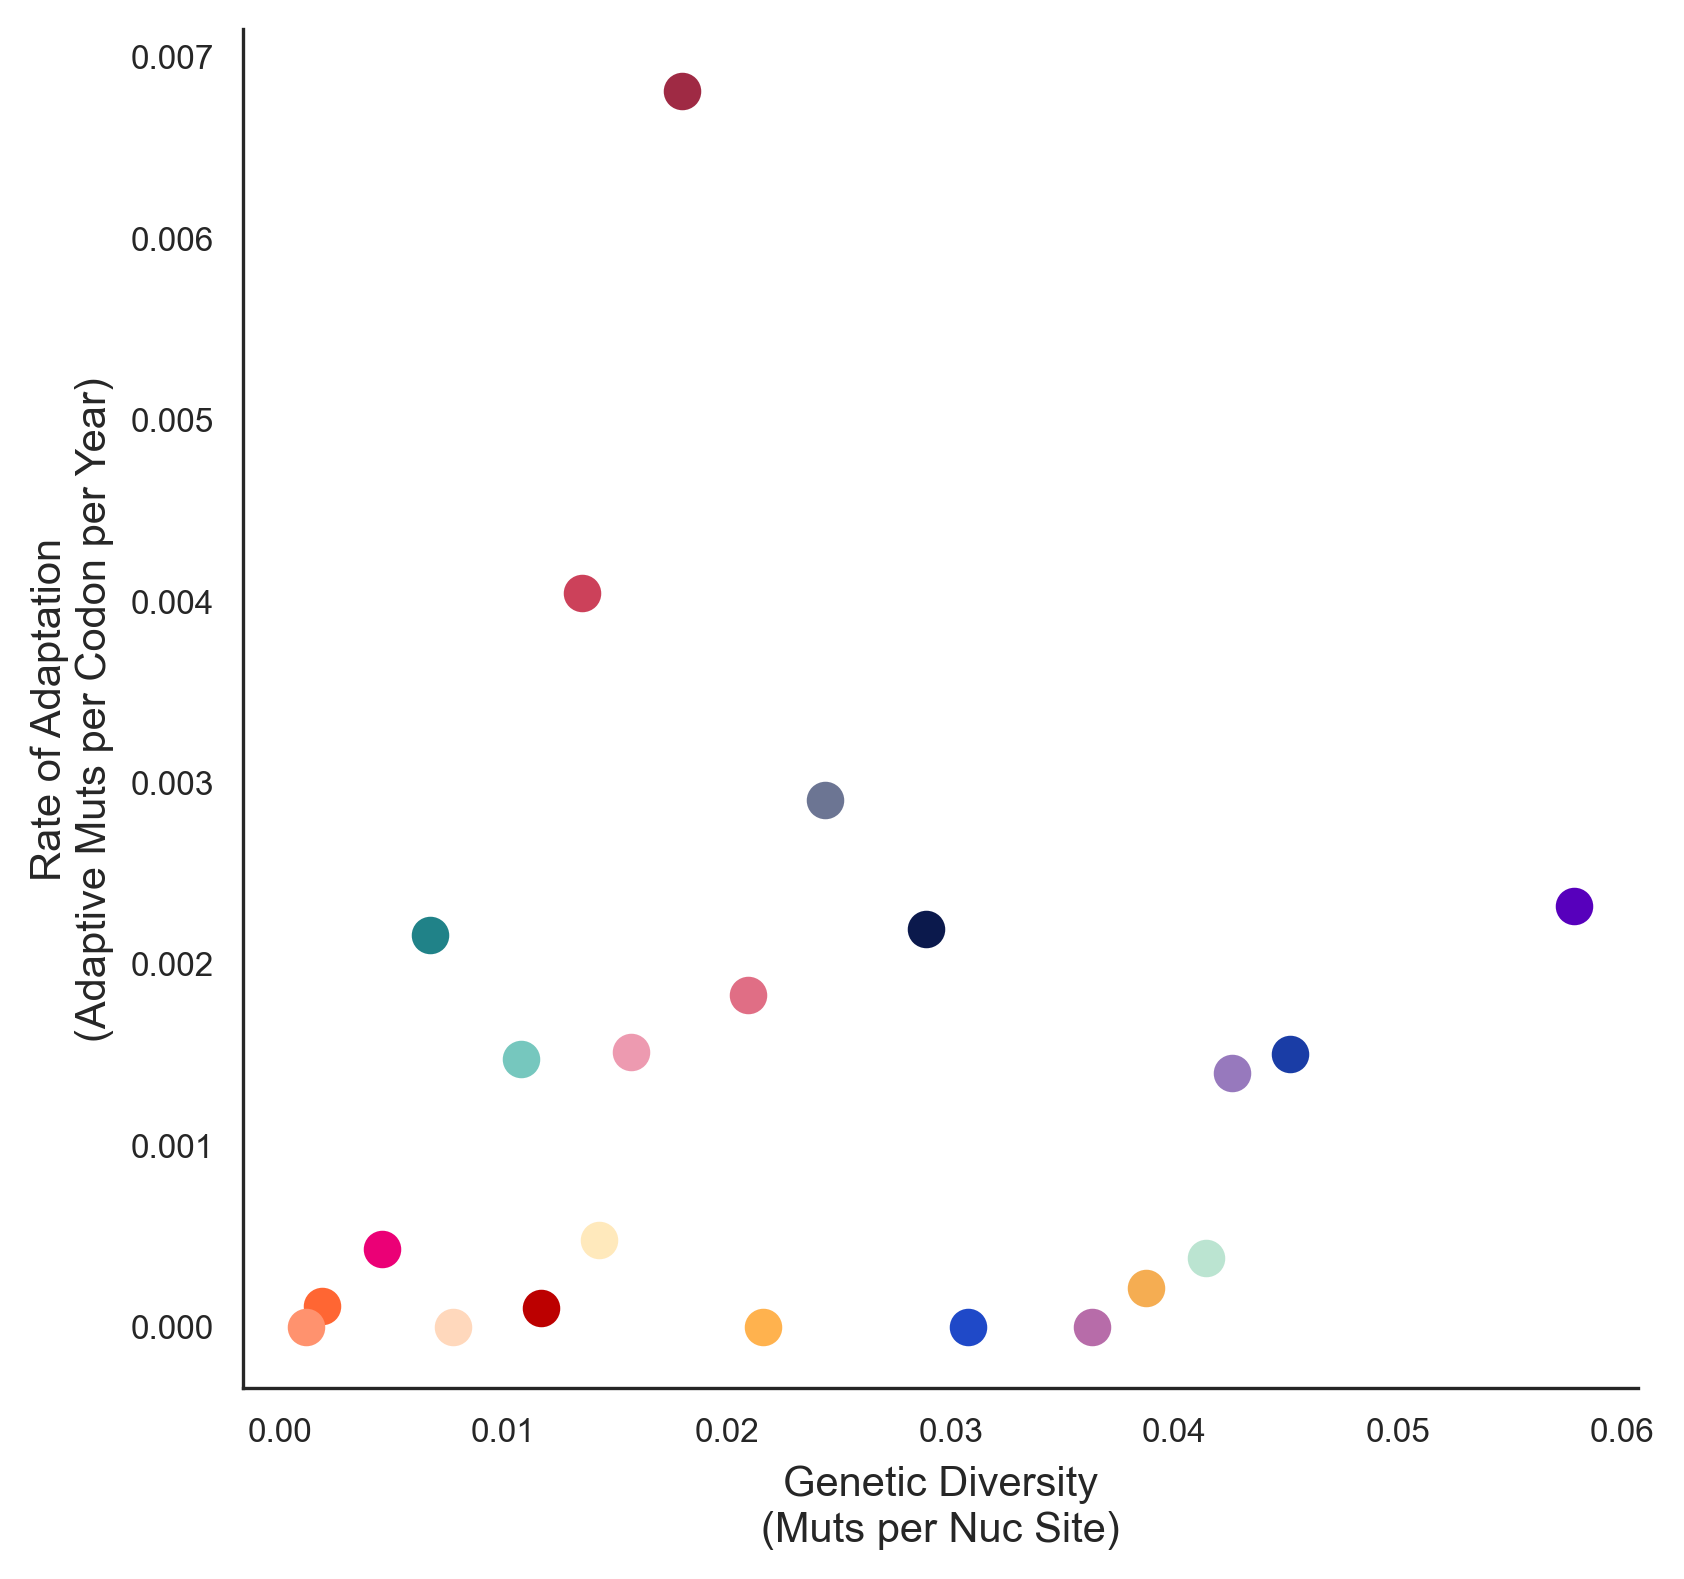

In [201]:
plot_diversity_adaptation(['h3n2', 'h1n1pdm', 'vic', 'yam', 'influenzaC_Yamagata',
                           'measles', '229e', 'nl63', 'oc43_A', 
                           'rsv_A', 'rsv_B', 'parainfluenza_1', 'parainfluenza_3', 
                           'enterovirusd68', 'norovirus', 'adenovirusB7', 'adenovirusB3', 
                           'parvovirusB19', 'rotavirusAg1p8', 'rotavirusAg1p4', 
                           'hepatitisA_IA', 'hepatitisB_A2', 'hepatitisB_D3'], 
                          method='kistler', pi_window=3)

adaptation analysis not run for parainfluenza_1


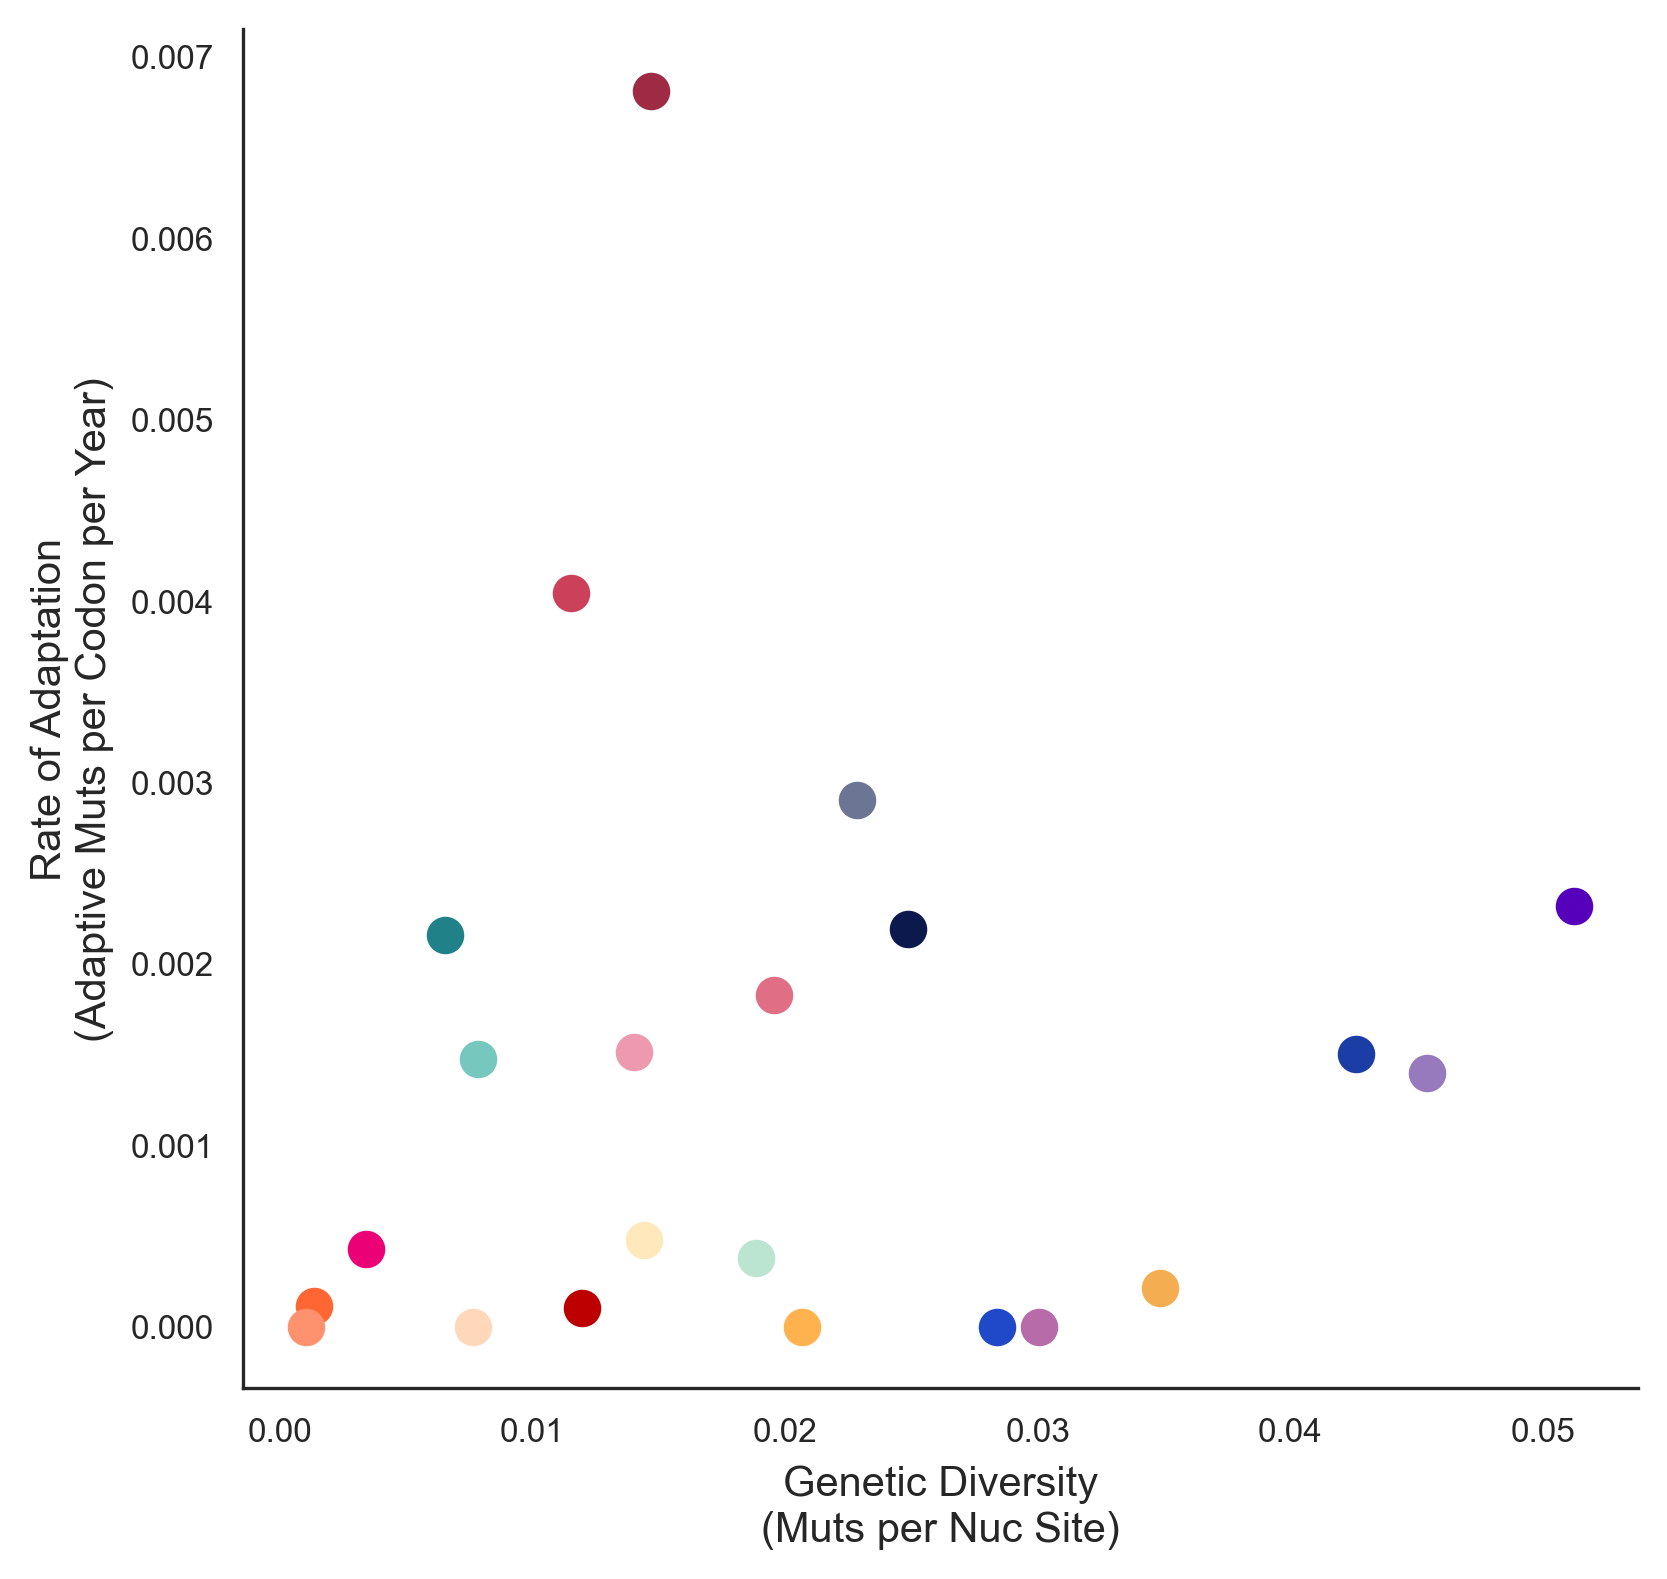

In [210]:
plot_diversity_adaptation(['h3n2', 'h1n1pdm', 'vic', 'yam', 'influenzaC_Yamagata',
                           'measles', '229e', 'nl63', 'oc43_A', 
                           'rsv_A', 'rsv_B', 'parainfluenza_1', 'parainfluenza_3', 
                           'enterovirusd68', 'norovirus', 'adenovirusB7', 'adenovirusB3', 
                           'parvovirusB19', 'rotavirusAg1p8', 'rotavirusAg1p4', 
                           'hepatitisA_IA', 'hepatitisB_A2', 'hepatitisB_D3'], 
                          method='kistler', pi_window=1)

adaptation analysis not run for parainfluenza_1


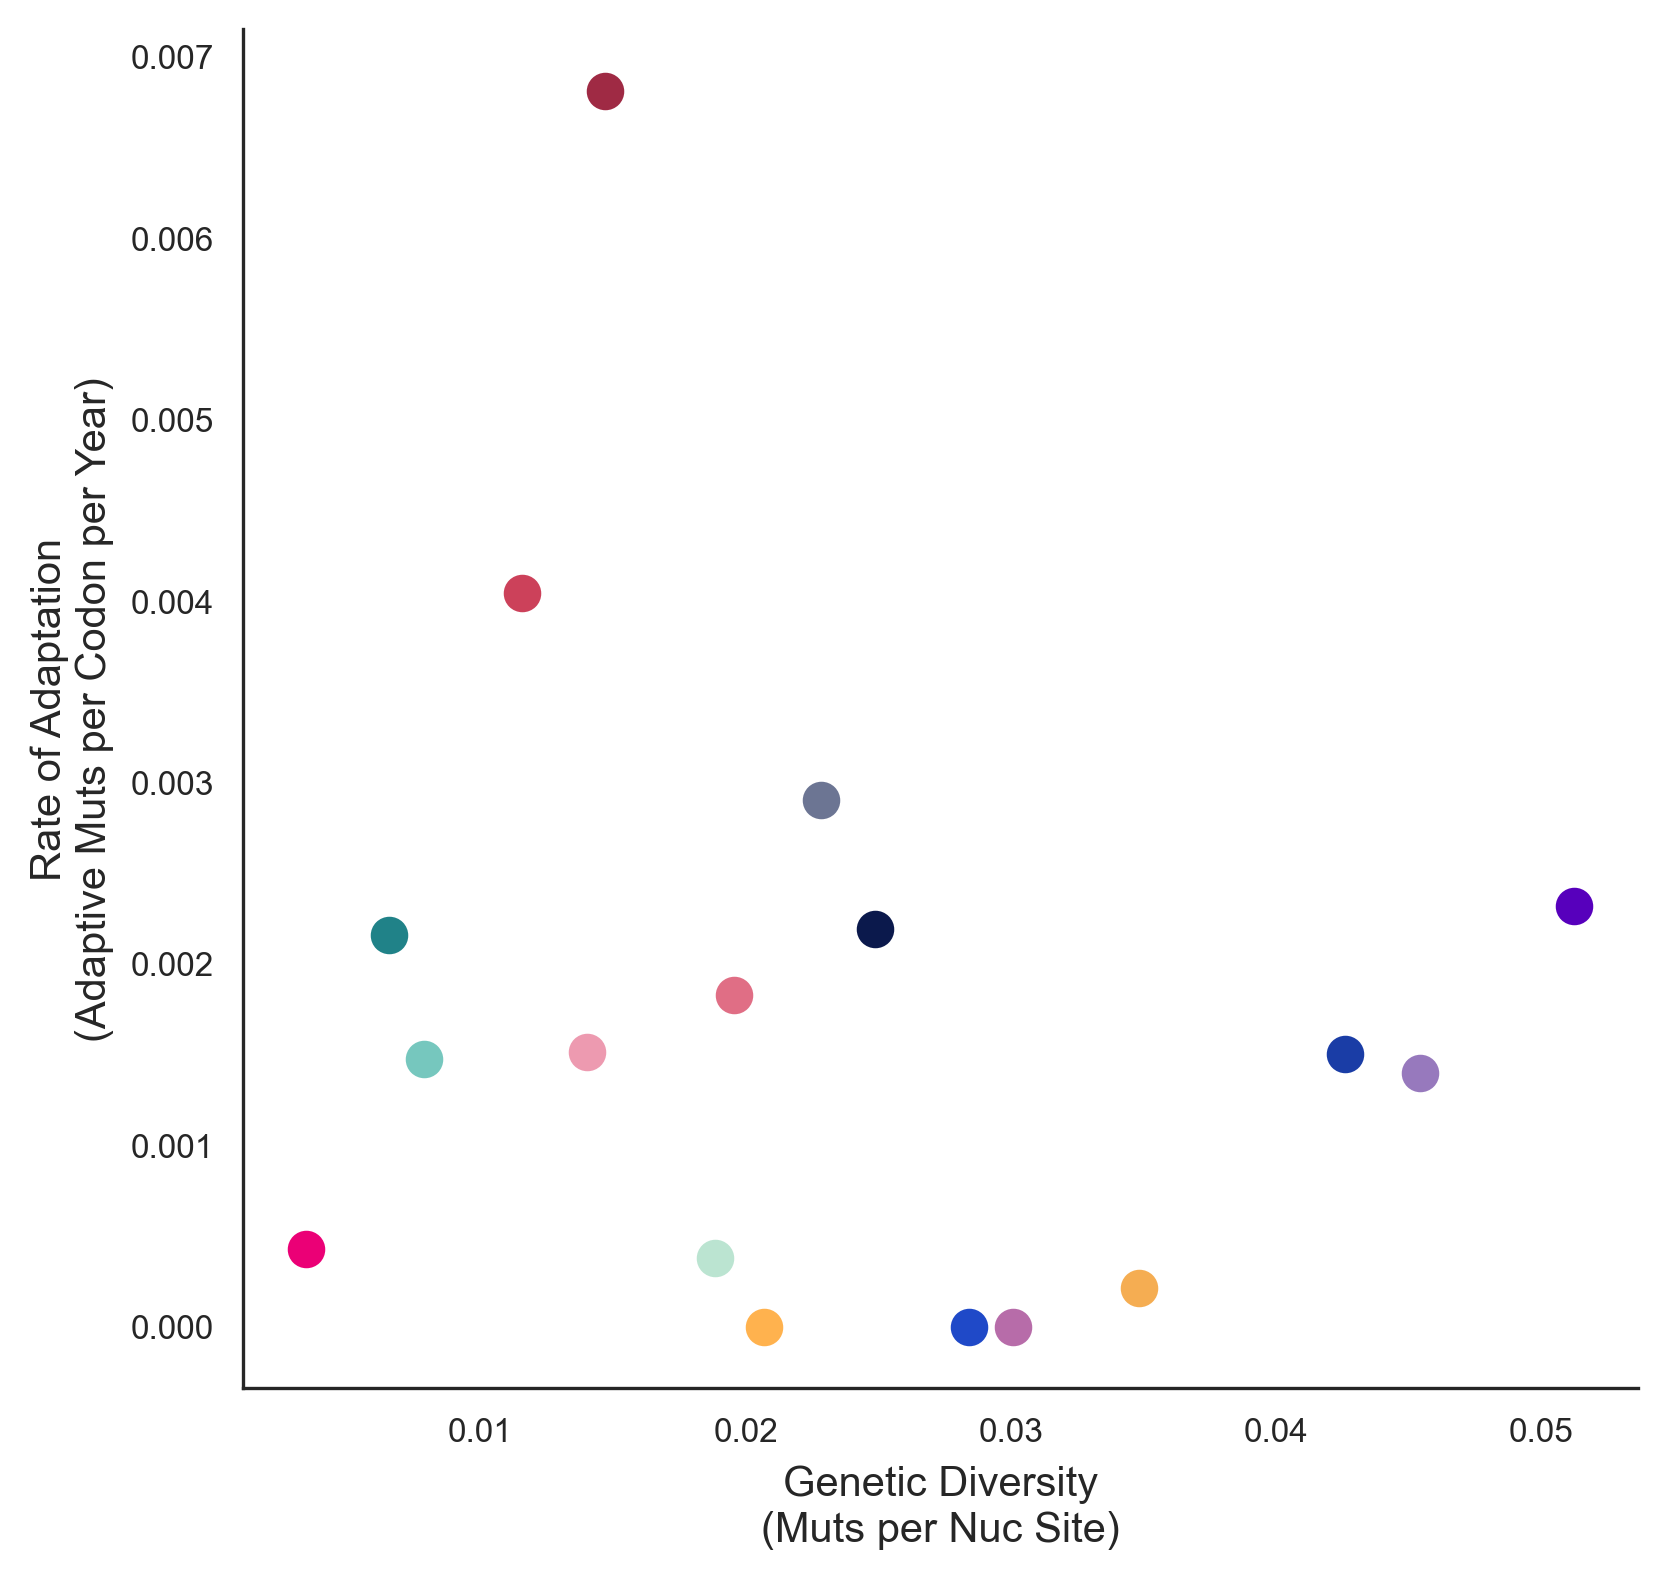

In [212]:
plot_diversity_adaptation(['h3n2', 'h1n1pdm', 'vic', 'yam', 'influenzaC_Yamagata',
                           'measles', '229e', 'nl63', 'oc43_A', 
                           'rsv_A', 'rsv_B', 'parainfluenza_1', 'parainfluenza_3', 
                           'enterovirusd68', 'norovirus', 'rotavirusAg1p8', 'rotavirusAg1p4', 
                           'hepatitisA_IA'], 
                          method='kistler', pi_window=1)